In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt 

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [2]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.make_merged_df()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
print(the_merged_df)

            date venue  raceNumber weather windDir  windPow  waveHight ruler  \
96    2019-01-01   　津　           1       晴      無風        0          0   抜き　   
97    2019-01-01   　津　           4       晴      東　        1          1   逃げ　   
98    2019-01-01   　津　           5       晴      東　        1          1   逃げ　   
99    2019-01-01   　津　           6       晴      東　        2          1   逃げ　   
100   2019-01-01   　津　           7       晴      東　        2          1   逃げ　   
101   2019-01-01   　津　           8       晴      東　        2          1   抜き　   
102   2019-01-01   　津　           9       晴      東　        1          1   逃げ　   
103   2019-01-01   　津　          10       晴      東　        1          1   逃げ　   
104   2019-01-01   　津　          11       曇      無風        0          0   逃げ　   
105   2019-01-01   　津　          12       曇      北西        3          2   逃げ　   
36    2019-01-01   下　関           1       曇      西　        7          7   逃げ　   
37    2019-01-01   下　関           2      

In [5]:
# 実行

# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []
for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各枠の平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    # 展示順位
    fv_list.append("exhibitionRank_{0}".format(i))
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))

# 解析に使うラベルカラム: 今回は一枠が一着になるかどうか？を予測
column_list_label = ["rank_1"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------


# 解析用dfを作成
for_analysis_df = the_merged_df[fv_list + column_list_label]

# クラスカラムを，A1 =0, A2 = 1のように数字に変換する
class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
for key, value in class_dict.items():
    for_analysis_df.replace(key, value, inplace = True)
    
# なぜかdtypeがstrになっちゃうのでintに戻す
for_analysis_df = for_analysis_df.astype(float)
# nanを含む行を削除
for_analysis_df = for_analysis_df.dropna()

# ラベルをbooleanに変換
for_analysis_df = analyzer_conf.make_label_boolean_ver1(
    for_analysis_df, column_list_label)
print("解析用dfの行数は.{0}".format(len(for_analysis_df)))

# 特徴量を標準化
for_analysis_df = analyzer_conf.standerdize_feature_values(
    for_analysis_df, column_list_label)

# 教師データとテストデータに分ける
train_size = int(len(for_analysis_df) * train_data_ratio)

train_data = for_analysis_df[:train_size].values
train_x = train_data[:, :-1]
train_t = train_data[:, -1]

test_data = for_analysis_df[train_size:].values
test_x = test_data[:, :-1]
test_t = test_data[:, -1]

# ロジスティック回帰
clf = LogisticRegression()
clf.fit(train_x, train_t)

C:\Users\griCe\Anaconda3\lib\site-packages\pandas\core\frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


解析用dfの行数は.22924


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
# 正解率を計算
train_score = clf.score(train_x, train_t)
test_score = clf.score(test_x, test_t)
print("trainデータを使った正解率は{0},\n \
      testデータを使った正解率は{1}".format(train_score, test_score))

# 最適化された結果の切片と重みを取得
intercept =clf.intercept_
coef = clf.coef_
print("切片は{0}".format(intercept))
for i in range (coef.shape[1]):
    print(fv_list[i], coef[0, i], "\n")

trainデータを使った正解率は0.6488221363579708,
       testデータを使った正解率は0.6497528351264903
切片は[0.20324089]
class_1 -0.43925572380363354 

aveST_frame1 -0.11454729135121165 

placeRate_frame1 0.27582561163453556 

exhibitionRank_1 -0.2328888789719407 

exhibitionTime_1 -0.45823404712193505 

class_2 0.05594213318201604 

aveST_frame2 -0.04636228801708379 

placeRate_frame2 -0.0882330528159359 

exhibitionRank_2 -0.07713722758217909 

exhibitionTime_2 0.17080057284187333 

class_3 0.022564962739594255 

aveST_frame3 0.01196363927707828 

placeRate_frame3 -0.038437477165127236 

exhibitionRank_3 -0.008582779443450332 

exhibitionTime_3 0.11288310629350812 

class_4 0.06780232752469724 

aveST_frame4 0.022630761127466165 

placeRate_frame4 -0.06094588998855049 

exhibitionRank_4 -0.009278227565360017 

exhibitionTime_4 0.1412566189388782 

class_5 0.04997985161649755 

aveST_frame5 0.02776120396829877 

placeRate_frame5 -0.04116149098870468 

exhibitionRank_5 0.019604306321590267 

exhibitionTime_5 -0.0

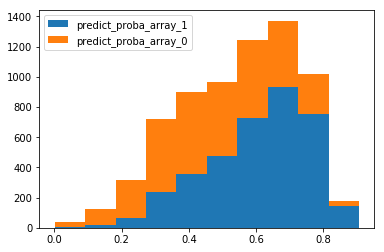

In [7]:
# 横軸に日付，縦軸に1着が1枠である可能性を結果で色分けして散布図を作成
predict_proba_array = clf.predict_proba(test_x)

# 結果が1 (1枠が一着) だったものの推定確率
predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

# 結果が0 (1枠以外が一着) だったものの推定確率
predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

# 積み上げヒストグラムを作成
labels = {'predict_proba_array_1', 'predict_proba_array_0'}

plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
plt.legend()
plt.show()

# 考察

逆に1着以外が1位になる，荒れるレースの予測がかなりうまくできそうな予感．
このregressionの値が0.3以下になるレースを選べば，かなりうまく"あれる予測"ができている．
てか上のほうを選べば，それなりの精度であれない予測もできている．
なんにしろ，値が大きいところ，小さいところではそれなりに確率に相関がみられるのは，使える感がある．